In [1]:
# Instalar librerías necesarias (solo si hace falta)
!pip install yfinance pyarrow ccxt
!pip install antropy
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 47.1 MB/s eta 0:00:00


In [ ]:
# Conectar con Google Drive para guardar datos
import yfinance as yf
import pandas as pd
import os
from google.colab import drive

drive.mount("/content/drive")
base_dir = "/content/drive/MyDrive/btc_prediction_project"
data_dir = os.path.join(base_dir, "data")
os.makedirs(data_dir, exist_ok=True)

btc_price = yf.download("BTC-USD", start="2010-01-01", end="2025-06-21", interval="1d")
btc_price.to_parquet(f"{data_dir}/btc_yfinance.parquet")

# Mostrar últimas filas como validación
btc_price.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-24-946171901.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_price = yf.download("BTC-USD", start="2010-01-01", end="2025-06-21", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [2]:
import pandas as pd
import os
from google.colab import drive
import numpy as np
from sklearn.cluster import KMeans
from antropy import sample_entropy
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [3]:
base_dir = "/content/drive/MyDrive/btc_prediction_project"
data_dir = os.path.join(base_dir, "data")
parquet_path = os.path.join(data_dir, "btc_yfinance.parquet")
csv_path = os.path.join(data_dir, "btc_yfinance.csv")

# 4. Leer el archivo Parquet
btc_df = pd.read_parquet(parquet_path)

# 5. Guardarlo como CSV
btc_df.to_csv(csv_path)

# 6. Mostrar una muestra del dataframe como validación
btc_df.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


Las columnas de un DataFrame pueden tener múltiples niveles cuando los datos provienen de fuentes que organizan la información jerárquicamente, como es el caso de yfinance al descargar datos financieros, donde se incluyen tanto la categoría del dato (por ejemplo, "Price") como el ticker (por ejemplo, "BTC-USD"). Este formato se representa en pandas como un MultiIndex en las columnas, lo que dificulta trabajar directamente con ellas en muchos casos. Aplanar las columnas significa convertir ese índice jerárquico en un índice simple, combinando los niveles en un solo nombre de columna, por ejemplo, uniendo la categoría y el ticker con un guion bajo. Esto facilita el manejo del DataFrame, permitiendo acceder a cada columna de manera directa y evitar confusiones por nombres repetidos. Si el DataFrame ya está aplanado, volver a aplanarlo podría provocar que los nombres se concatenen repetidamente, por eso se verifica si el índice es un MultiIndex antes de hacer esta transformación.

In [4]:
# Aplana las columnas uniendo los niveles del MultiIndex
if isinstance(btc_df.columns, pd.MultiIndex):
    btc_df.columns = [f"{col[0]}_{col[1]}" for col in btc_df.columns]
    print("Columnas aplanadas...")
else:
    print("Las columnas ya están aplanadas.")

Columnas aplanadas...


In [5]:
# Usamos directamente 'Close_BTC-USD'
btc_df = btc_df[["Close_BTC-USD"]].dropna().reset_index(drop=True)

# Dividir en 3 partes
total_len = len(btc_df)
tercio = total_len // 3

parte_a = btc_df.iloc[:tercio].copy()
parte_b = btc_df.iloc[tercio:2*tercio].copy()
parte_c = btc_df.iloc[2*tercio:].copy()

print(f"Total: {total_len} — Parte A: {len(parte_a)}, B: {len(parte_b)}, C: {len(parte_c)}")

# Extraer ventanas deslizantes z-normalizadas usando 'Close_BTC-USD'
def extract_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        w = data["Close_BTC-USD"].iloc[i:i+window_size].values
        w = (w - w.mean()) / w.std()
        windows.append(w)
    return np.array(windows)

windows_180 = extract_windows(parte_a, 180)
windows_360 = extract_windows(parte_a, 360)
windows_720 = extract_windows(parte_a, 720)

print("Ventanas 180:", windows_180.shape)
print("Ventanas 360:", windows_360.shape)
print("Ventanas 720:", windows_720.shape)
#-------------------------------------------------------

def fit_kmeans(windows, n_clusters=100):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(windows)
    return kmeans.cluster_centers_, kmeans

centers_180, kmeans_180 = fit_kmeans(windows_180)
centers_360, kmeans_360 = fit_kmeans(windows_360)
centers_720, kmeans_720 = fit_kmeans(windows_720)

print("Centros obtenidos:", centers_180.shape, centers_360.shape, centers_720.shape)

#-------------------------------------------------------

def select_top_entropy(centers, top_k=50):
    entropias = [sample_entropy(c) for c in centers]
    idx = np.argsort(entropias)[-top_k:]
    return centers[idx], np.array(entropias)[idx]

top20_180, entrop_180 = select_top_entropy(centers_180)
top20_360, entrop_360 = select_top_entropy(centers_360)
top20_720, entrop_720 = select_top_entropy(centers_720)

print("Top entropías 180:", entrop_180)

#-------------------------------------------------------

def dp_vector(window, patterns):
    sim = np.array([np.dot(window, p)/(np.linalg.norm(window)*np.linalg.norm(p)) for p in patterns])
    return sim

def bayesian_error(weights, X, y):
    preds = X.dot(weights)
    return np.mean((preds - y)**2) + 1e-6*np.sum(weights**2)

#-------------------------------------------------------

def build_design_matrix(data, patterns, window_size):
    X, y = [], []
    closes = data["Close_BTC-USD"].values
    for i in range(len(data)-window_size-1):
        w = closes[i:i+window_size]
        w = (w - w.mean())/w.std()
        dp = dp_vector(w, patterns)
        X.append(dp)
        y.append((closes[i+window_size+1] - closes[i+window_size]) - 1)
    return np.array(X), np.array(y)

Xb_180, yb_180 = build_design_matrix(parte_b, top20_180, 180)

#-------------------------------------------------------

from sklearn.linear_model import Ridge

model = Ridge(alpha=1e-6)  # como tu regularización pequeña
model.fit(Xb_180, yb_180)
w_opt_180 = model.coef_  # equivalente a los "pesos"



#-------------------------------------------------------

def predict_and_eval(data, patterns, weights, window_size):
    closes = data["Close_BTC-USD"].values
    preds, actual = [], []
    for i in range(len(data)-window_size-1):
        w = closes[i:i+window_size]
        w = (w - w.mean())/w.std()
        dp = dp_vector(w, patterns)
        pred = dp.dot(weights)
        preds.append(pred)
        actual.append(closes[i+window_size+1] - closes[i+window_size])
    preds, actual = np.array(preds), np.array(actual)
    acc = np.mean(np.sign(preds) == np.sign(actual))
    return acc, preds, actual

acc_180, pred_180, act_180 = predict_and_eval(parte_c, top20_180, w_opt_180, 180)
print(f"Accuracy 180 días: {acc_180:.2%}")

Total: 3930 — Parte A: 1310, B: 1310, C: 1310
Ventanas 180: (1130, 180)
Ventanas 360: (950, 360)
Ventanas 720: (590, 720)
Centros obtenidos: (100, 180) (100, 360) (100, 720)
Top entropías 180: [0.17653476 0.17855862 0.17950614 0.18604596 0.18692229 0.18740665
 0.18838925 0.18954532 0.1904113  0.19220886 0.19428472 0.19454809
 0.19972386 0.20424393 0.20703238 0.20710159 0.21474682 0.21525447
 0.22804824 0.23049352 0.23339527 0.23487225 0.23723391 0.2395942
 0.24023798 0.24206161 0.24878317 0.25074544 0.26231698 0.2752135
 0.28228118 0.29128964 0.29425384 0.2954217  0.30596878 0.30924785
 0.32034076 0.33234284 0.33498174 0.34866751 0.3530472  0.35321442
 0.36092725 0.37301794 0.38802483 0.39639475 0.43894623 0.44468582
 0.50411713 0.65370003]
Accuracy 180 días: 51.73%


In [6]:
# Construcción matriz de diseño
Xb_360, yb_360 = build_design_matrix(parte_b, top20_360, 360)

# Optimización de pesos
model_360 = Ridge(alpha=1e-6)
model_360.fit(Xb_360, yb_360)
w_opt_360 = model_360.coef_

# Evaluación
acc_360, pred_360, act_360 = predict_and_eval(parte_c, top20_360, w_opt_360, 360)
print(f"Accuracy 360 días: {acc_360:.2%}")


Accuracy 360 días: 47.73%


In [7]:
# Construcción matriz de diseño
Xb_720, yb_720 = build_design_matrix(parte_b, top20_720, 720)

# Optimización de pesos
res_720 = differential_evolution(
    lambda w: bayesian_error(w, Xb_720, yb_720),
    bounds=[(-1,1)] * Xb_720.shape[1],
    maxiter=200, seed=42
)
w_opt_720 = res_720.x

# Evaluación
acc_720, pred_720, act_720 = predict_and_eval(parte_c, top20_720, w_opt_720, 720)
print(f"Accuracy 720 días: {acc_720:.2%}")


Accuracy 720 días: 51.44%


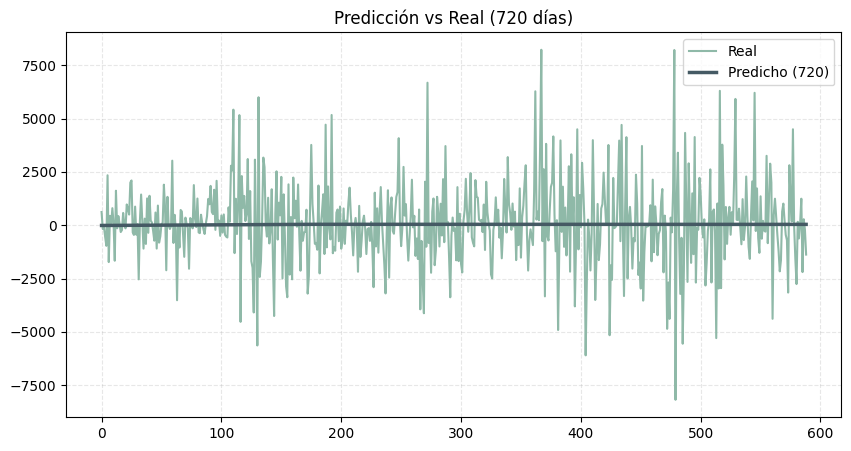

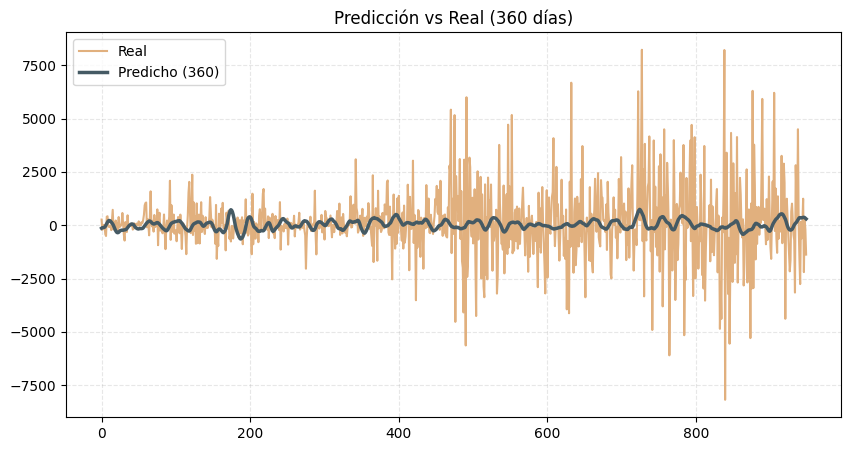

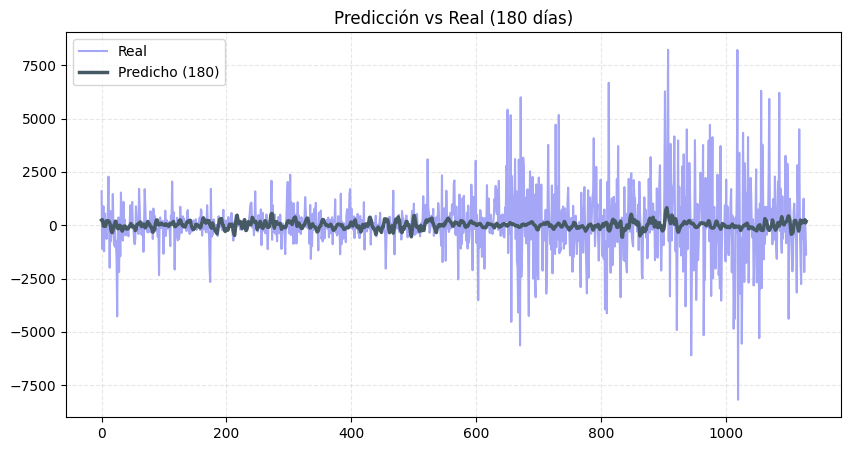

In [8]:
# Línea predicha: constante en color y más ancha
pred_color = '#455A64'  # gris azulado sobrio
pred_width = 2.5

plt.figure(figsize=(10,5))
plt.plot(act_720, label="Real", color='#8FB9A8', linewidth=1.5)  # verde pastel
plt.plot(pred_720, label="Predicho (720)", color=pred_color, linewidth=pred_width)
plt.title("Predicción vs Real (720 días)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(act_360, label="Real", color='#E1B07E', linewidth=1.5)  # naranja suave
plt.plot(pred_360, label="Predicho (360)", color=pred_color, linewidth=pred_width)
plt.title("Predicción vs Real (360 días)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(act_180, label="Real", color='#A5A6F6', linewidth=1.5)  # azul lavanda
plt.plot(pred_180, label="Predicho (180)", color=pred_color, linewidth=pred_width)
plt.title("Predicción vs Real (180 días)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [9]:
# Cortar todas las predicciones al mínimo largo común
min_len = min(len(pred_180), len(pred_360), len(pred_720))

p180 = pred_180[:min_len]
p360 = pred_360[:min_len]
p720 = pred_720[:min_len]
a = act_180[:min_len]  # usamos act_180 como referencia

# Promedio de predicciones (modelo de ensamble)
ensemble_pred = (p180 + p360 + p720) / 3

# Evaluar accuracy del modelo combinado
ensemble_acc = np.mean(np.sign(ensemble_pred) == np.sign(a))
print(f"✅ Accuracy modelo combinado: {ensemble_acc:.2%}")


# Baseline: "mañana sube si hoy subió"
baseline_acc = np.mean(np.sign(np.diff(parte_c["Close_BTC-USD"].values))[:-1] ==
                       np.sign(np.diff(parte_c["Close_BTC-USD"].values))[1:])
print(f"Baseline accuracy: {baseline_acc:.2%}")



✅ Accuracy modelo combinado: 50.08%
Baseline accuracy: 47.63%


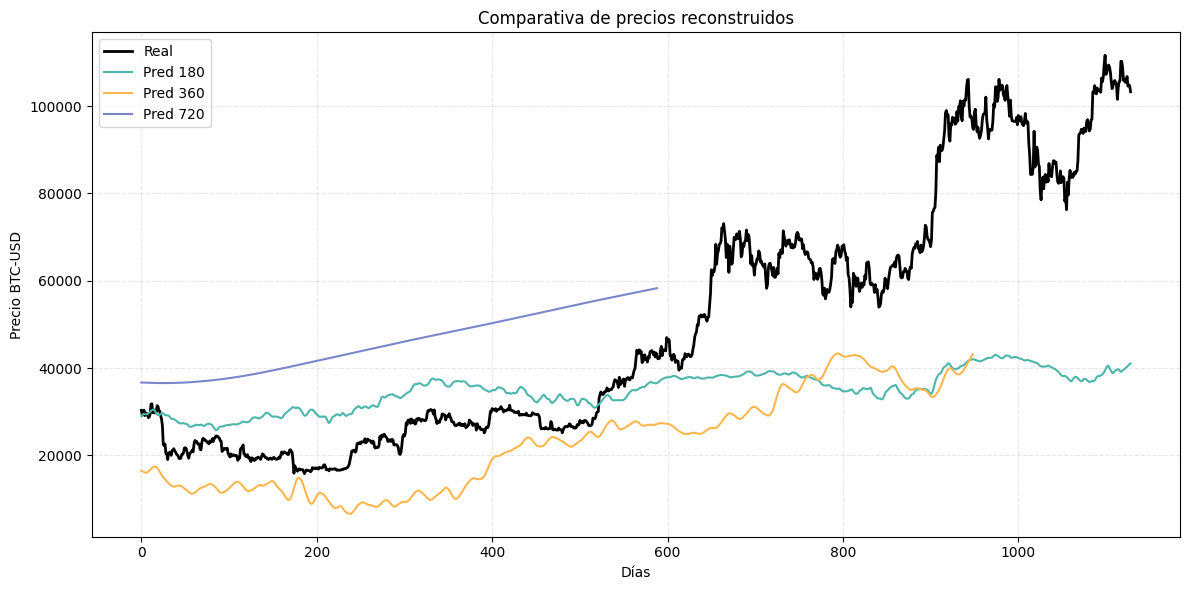

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(act_180) + btc_df["Close_BTC-USD"].iloc[-len(act_180)-1], label="Real", color='black', linewidth=2)

plt.plot(np.cumsum(pred_180) + btc_df["Close_BTC-USD"].iloc[-len(pred_180)-1], label="Pred 180", color="#4DB6AC")
plt.plot(np.cumsum(pred_360) + btc_df["Close_BTC-USD"].iloc[-len(pred_360)-1], label="Pred 360", color="#FFB74D")
plt.plot(np.cumsum(pred_720) + btc_df["Close_BTC-USD"].iloc[-len(pred_720)-1], label="Pred 720", color="#7986CB")

plt.title("Comparativa de precios reconstruidos")
plt.xlabel("Días")
plt.ylabel("Precio BTC-USD")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Cargar el dataset desde el parquet
df = pd.read_parquet(f"{data_dir}/btc_yfinance.parquet")

# Asegurarse de que el índice sea datetime (por si acaso)
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# Calcular la diferencia entre las fechas
intervalos = df.index.to_series().diff().dropna()

# Obtener la frecuencia más común
frecuencia_mas_comun = intervalos.mode()[0]

print(f"Frecuencia más común: {frecuencia_mas_comun}")

Frecuencia más común: 1 days 00:00:00
